In [42]:
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin,BaseEstimator
from datetime import datetime
from datetime import date
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_palette("mako")

In [43]:
def find_outliers(data,column):
    data_mean, data_std=np.mean(data),np.std(data)
    cut_off=data_std*3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers=[x for x in data if x<lower or x >upper]
    print('Počet outlierov v stĺpci ' + column +  ' je %d' % len(outliers))

In [44]:
def findDiffCorrelation(tmp_data):
    return (tmp_data.iloc[: , :15].corr() - data.iloc[: , :15].corr()).max()

In [45]:
def transform_col(dataframe, column):
        quartil_down = dataframe[column].quantile(0.05)
        quartil_up = dataframe[column].quantile(0.95)
        
        for i, value in dataframe.iterrows():
            if value[column] < quartil_down:
                dataframe.loc[i, column] = quartil_down
            elif value[column] > quartil_up:
                dataframe.loc[i, column] = quartil_up
        return dataframe
def transform(dataframe):
    col_names= list(dataframe.columns.values)
    col_names = col_names[0:17]
    for column_name in col_names:
        transform_col(dataframe,column_name)
    return dataframe

### Načítanie a čistenie dát

In [46]:
stations= pd.read_csv("data/stations.csv", sep="\t")
measurements= pd.read_csv("data/measurements.csv", sep="\t")

In [47]:
measurements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12128 entries, 0 to 12127
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       12080 non-null  float64
 1   PM10       12079 non-null  float64
 2   C2H3NO5    12079 non-null  float64
 3   O3         12079 non-null  float64
 4   NH3        12080 non-null  float64
 5   Pb         12079 non-null  float64
 6   PRES       12128 non-null  float64
 7   CFCs       12079 non-null  float64
 8   longitude  12128 non-null  float64
 9   SO2        12079 non-null  float64
 10  latitude   12128 non-null  float64
 11  NOx        12078 non-null  float64
 12  warning    12079 non-null  float64
 13  CO         12079 non-null  float64
 14  CH4        12079 non-null  float64
 15  PM2.5      12080 non-null  float64
 16  H2CO       12080 non-null  float64
 17  TEMP       12080 non-null  float64
dtypes: float64(18)
memory usage: 1.7 MB


In [48]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1051 entries, 0 to 1050
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   station    1051 non-null   object 
 1   latitude   1051 non-null   float64
 2   code       1050 non-null   object 
 3   revision   1051 non-null   object 
 4   QoS        1051 non-null   object 
 5   longitude  1051 non-null   float64
dtypes: float64(2), object(4)
memory usage: 49.4+ KB


Skontrolujeme, či sú jednotlivé 'latitude' jedinečné, a podľa nich joineme.

In [49]:
latitude_s = stations["latitude"].unique().sort()
latitude_m = measurements["latitude"].unique().sort()
np.array_equal(latitude_s, latitude_m)

True

Sú rovnaké, preto môžeme ich spojiť.
Odstránime QoS, revision a code, keďže tieto parametre neovplyvňujú kvalitu ovzdušia.Taktiež odstránime duplicitný stĺpec ktorý nám vznikne.

In [50]:
stations.drop(columns=["QoS"], inplace=True)
stations.drop(columns=["revision"], inplace=True)
stations.drop(columns=["code"], inplace=True)
data = pd.merge(measurements, stations, on = ["latitude"], how = "left")
data.drop(columns=["longitude_x"], inplace=True)
data.rename(columns={'longitude_y': 'longitude'}, inplace=True)
data_orig = data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25540 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       25447 non-null  float64
 1   PM10       25437 non-null  float64
 2   C2H3NO5    25444 non-null  float64
 3   O3         25435 non-null  float64
 4   NH3        25448 non-null  float64
 5   Pb         25435 non-null  float64
 6   PRES       25540 non-null  float64
 7   CFCs       25447 non-null  float64
 8   SO2        25434 non-null  float64
 9   latitude   25540 non-null  float64
 10  NOx        25443 non-null  float64
 11  warning    25427 non-null  float64
 12  CO         25437 non-null  float64
 13  CH4        25442 non-null  float64
 14  PM2.5      25434 non-null  float64
 15  H2CO       25443 non-null  float64
 16  TEMP       25438 non-null  float64
 17  station    25540 non-null  object 
 18  longitude  25540 non-null  float64
dtypes: float64(18), object(1)
memory usage: 3.9+ M

Ukážka dát po spojení.

In [51]:
data.head()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,station,longitude
0,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
1,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
2,7.22628,9.07079,2.63533,9.95652,9.21864,29.98802,1093.16157,67.38361,9.89682,-5.85746,10.31364,0.0,8.36810,9.75090,10.19732,59.16382,1.58478,Mount Hagen,144.23058
3,10.39372,8.25541,1.19707,8.98772,9.82297,47.15361,1063.43896,69.62954,8.29285,8.88649,10.26103,0.0,8.47772,9.60717,7.09990,65.37280,13.19832,Tchaourou,2.59753
4,9.56441,8.43278,1.32137,4.43270,8.08426,47.94224,1111.55551,77.84035,8.42276,10.10649,6.11983,1.0,8.97045,8.89398,8.22953,47.62991,3.92248,Alwaye,76.35484


Odstránime duplicitné záznamy

In [52]:
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 13591


In [53]:
data = data.drop_duplicates()
tmp = data.duplicated()
tmp = tmp[tmp == True].count()
print('Počet duplicitných záznamov: '+ str(tmp))

Počet duplicitných záznamov: 0


In [54]:
data.describe()

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,latitude,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,longitude
count,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11949.00000,11901.000000,11901.000000,11949.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11901.000000,11949.000000
mean,8.793407,8.795797,3.346339,9.315354,8.802845,49.793778,1125.26050,72.087720,8.815813,28.522628,9.316578,0.595664,8.800033,9.312754,8.780025,50.788099,14.925675,8.634207
std,2.075479,0.991844,4.069032,1.906690,0.993455,12.757519,43.27262,7.170915,1.946974,23.364543,1.692003,0.490784,1.002546,1.904321,2.078473,13.924619,9.950045,72.929082
min,1.925340,5.187260,0.000000,2.048720,5.124910,0.000000,1050.00071,0.000000,1.029620,-54.800000,2.304540,0.000000,5.032870,2.492000,0.000000,0.000000,-26.219360,-156.474320
25%,7.339640,8.130800,1.198020,8.123430,8.129190,41.236540,1087.74162,67.287060,7.425060,13.701670,8.381980,0.000000,8.126820,8.034840,7.307000,41.500110,8.169370,-67.154070
50%,8.856240,8.792160,2.135070,9.473560,8.802850,49.716590,1125.78376,72.132440,8.989670,36.208290,9.640500,1.000000,8.808710,9.426420,8.628970,50.682700,14.908990,7.227800
75%,10.276030,9.462440,3.938000,10.662760,9.460690,58.356560,1162.63878,76.898340,10.213520,45.040800,10.487290,1.000000,9.474830,10.651500,10.259350,60.117480,21.692530,68.888710
max,17.068470,12.750440,100.000000,15.619060,12.763030,100.000000,1199.97470,100.000000,15.856800,68.798330,14.915300,1.000000,12.576710,16.569680,16.646230,100.000000,52.722610,178.004170


Presunieme si latitude a longtitude na koniec, aby sme vedeli neskôr ľahšie vyberať parametre ovplyvňujúce kvalitu ovzdušia.

In [55]:
data.insert(16, 'latitude', data.pop('latitude'))
data.insert(17, 'longitude', data.pop('longitude'))
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11949 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       11901 non-null  float64
 1   PM10       11901 non-null  float64
 2   C2H3NO5    11901 non-null  float64
 3   O3         11901 non-null  float64
 4   NH3        11901 non-null  float64
 5   Pb         11901 non-null  float64
 6   PRES       11949 non-null  float64
 7   CFCs       11901 non-null  float64
 8   SO2        11901 non-null  float64
 9   NOx        11901 non-null  float64
 10  warning    11901 non-null  float64
 11  CO         11901 non-null  float64
 12  CH4        11901 non-null  float64
 13  PM2.5      11901 non-null  float64
 14  H2CO       11901 non-null  float64
 15  TEMP       11901 non-null  float64
 16  latitude   11949 non-null  float64
 17  longitude  11949 non-null  float64
 18  station    11949 non-null  object 
dtypes: float64(18), object(1)
memory usage: 1.8+ M

### Odstránenie NA hodnôt
Ako prvé skúsime metódu s odstránením riadkov, kde chýbajú hodnoty.

In [58]:
data = data.dropna(subset = ['warning'])
data.warning.unique()

array([0., 1.])

In [59]:
tmp_data = data.copy()
tmp_data.dropna(inplace=True)
tmp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11247 entries, 0 to 25539
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       11247 non-null  float64
 1   PM10       11247 non-null  float64
 2   C2H3NO5    11247 non-null  float64
 3   O3         11247 non-null  float64
 4   NH3        11247 non-null  float64
 5   Pb         11247 non-null  float64
 6   PRES       11247 non-null  float64
 7   CFCs       11247 non-null  float64
 8   SO2        11247 non-null  float64
 9   NOx        11247 non-null  float64
 10  warning    11247 non-null  float64
 11  CO         11247 non-null  float64
 12  CH4        11247 non-null  float64
 13  PM2.5      11247 non-null  float64
 14  H2CO       11247 non-null  float64
 15  TEMP       11247 non-null  float64
 16  latitude   11247 non-null  float64
 17  longitude  11247 non-null  float64
 18  station    11247 non-null  object 
dtypes: float64(18), object(1)
memory usage: 1.7+ M

In [60]:
len(data) - len(tmp_data)


654

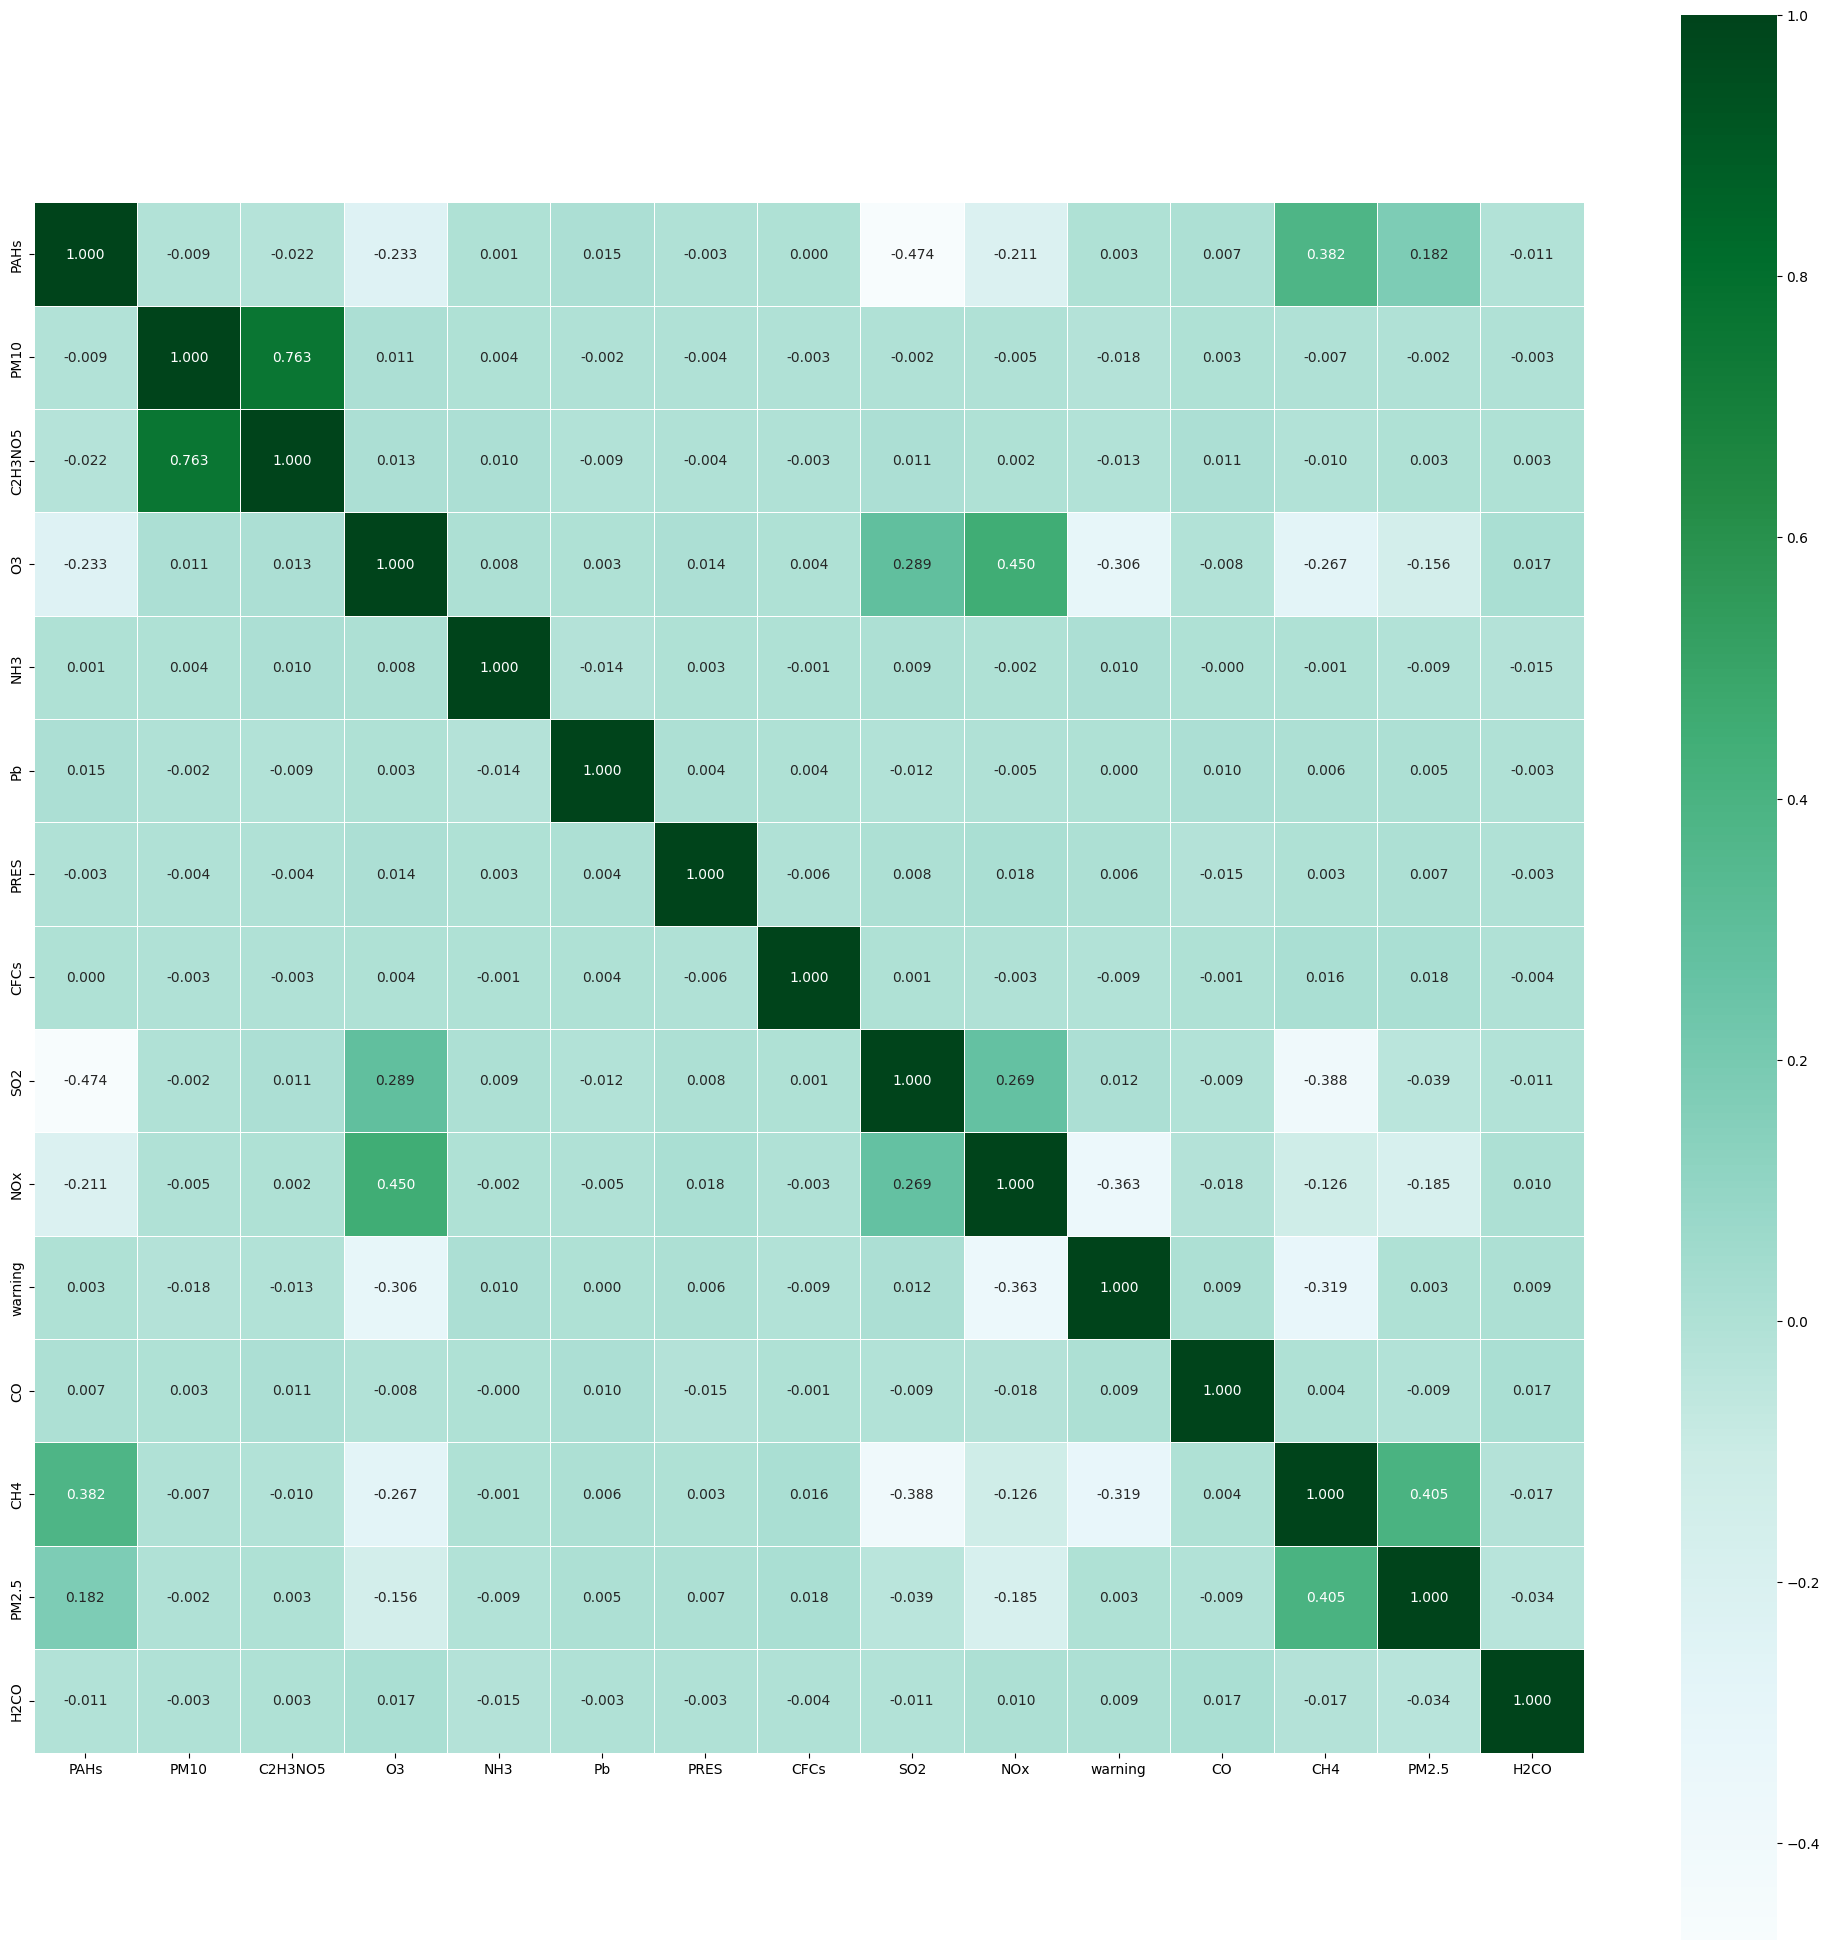

In [61]:
plt.figure(figsize=(25,25))
sns.heatmap(data.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

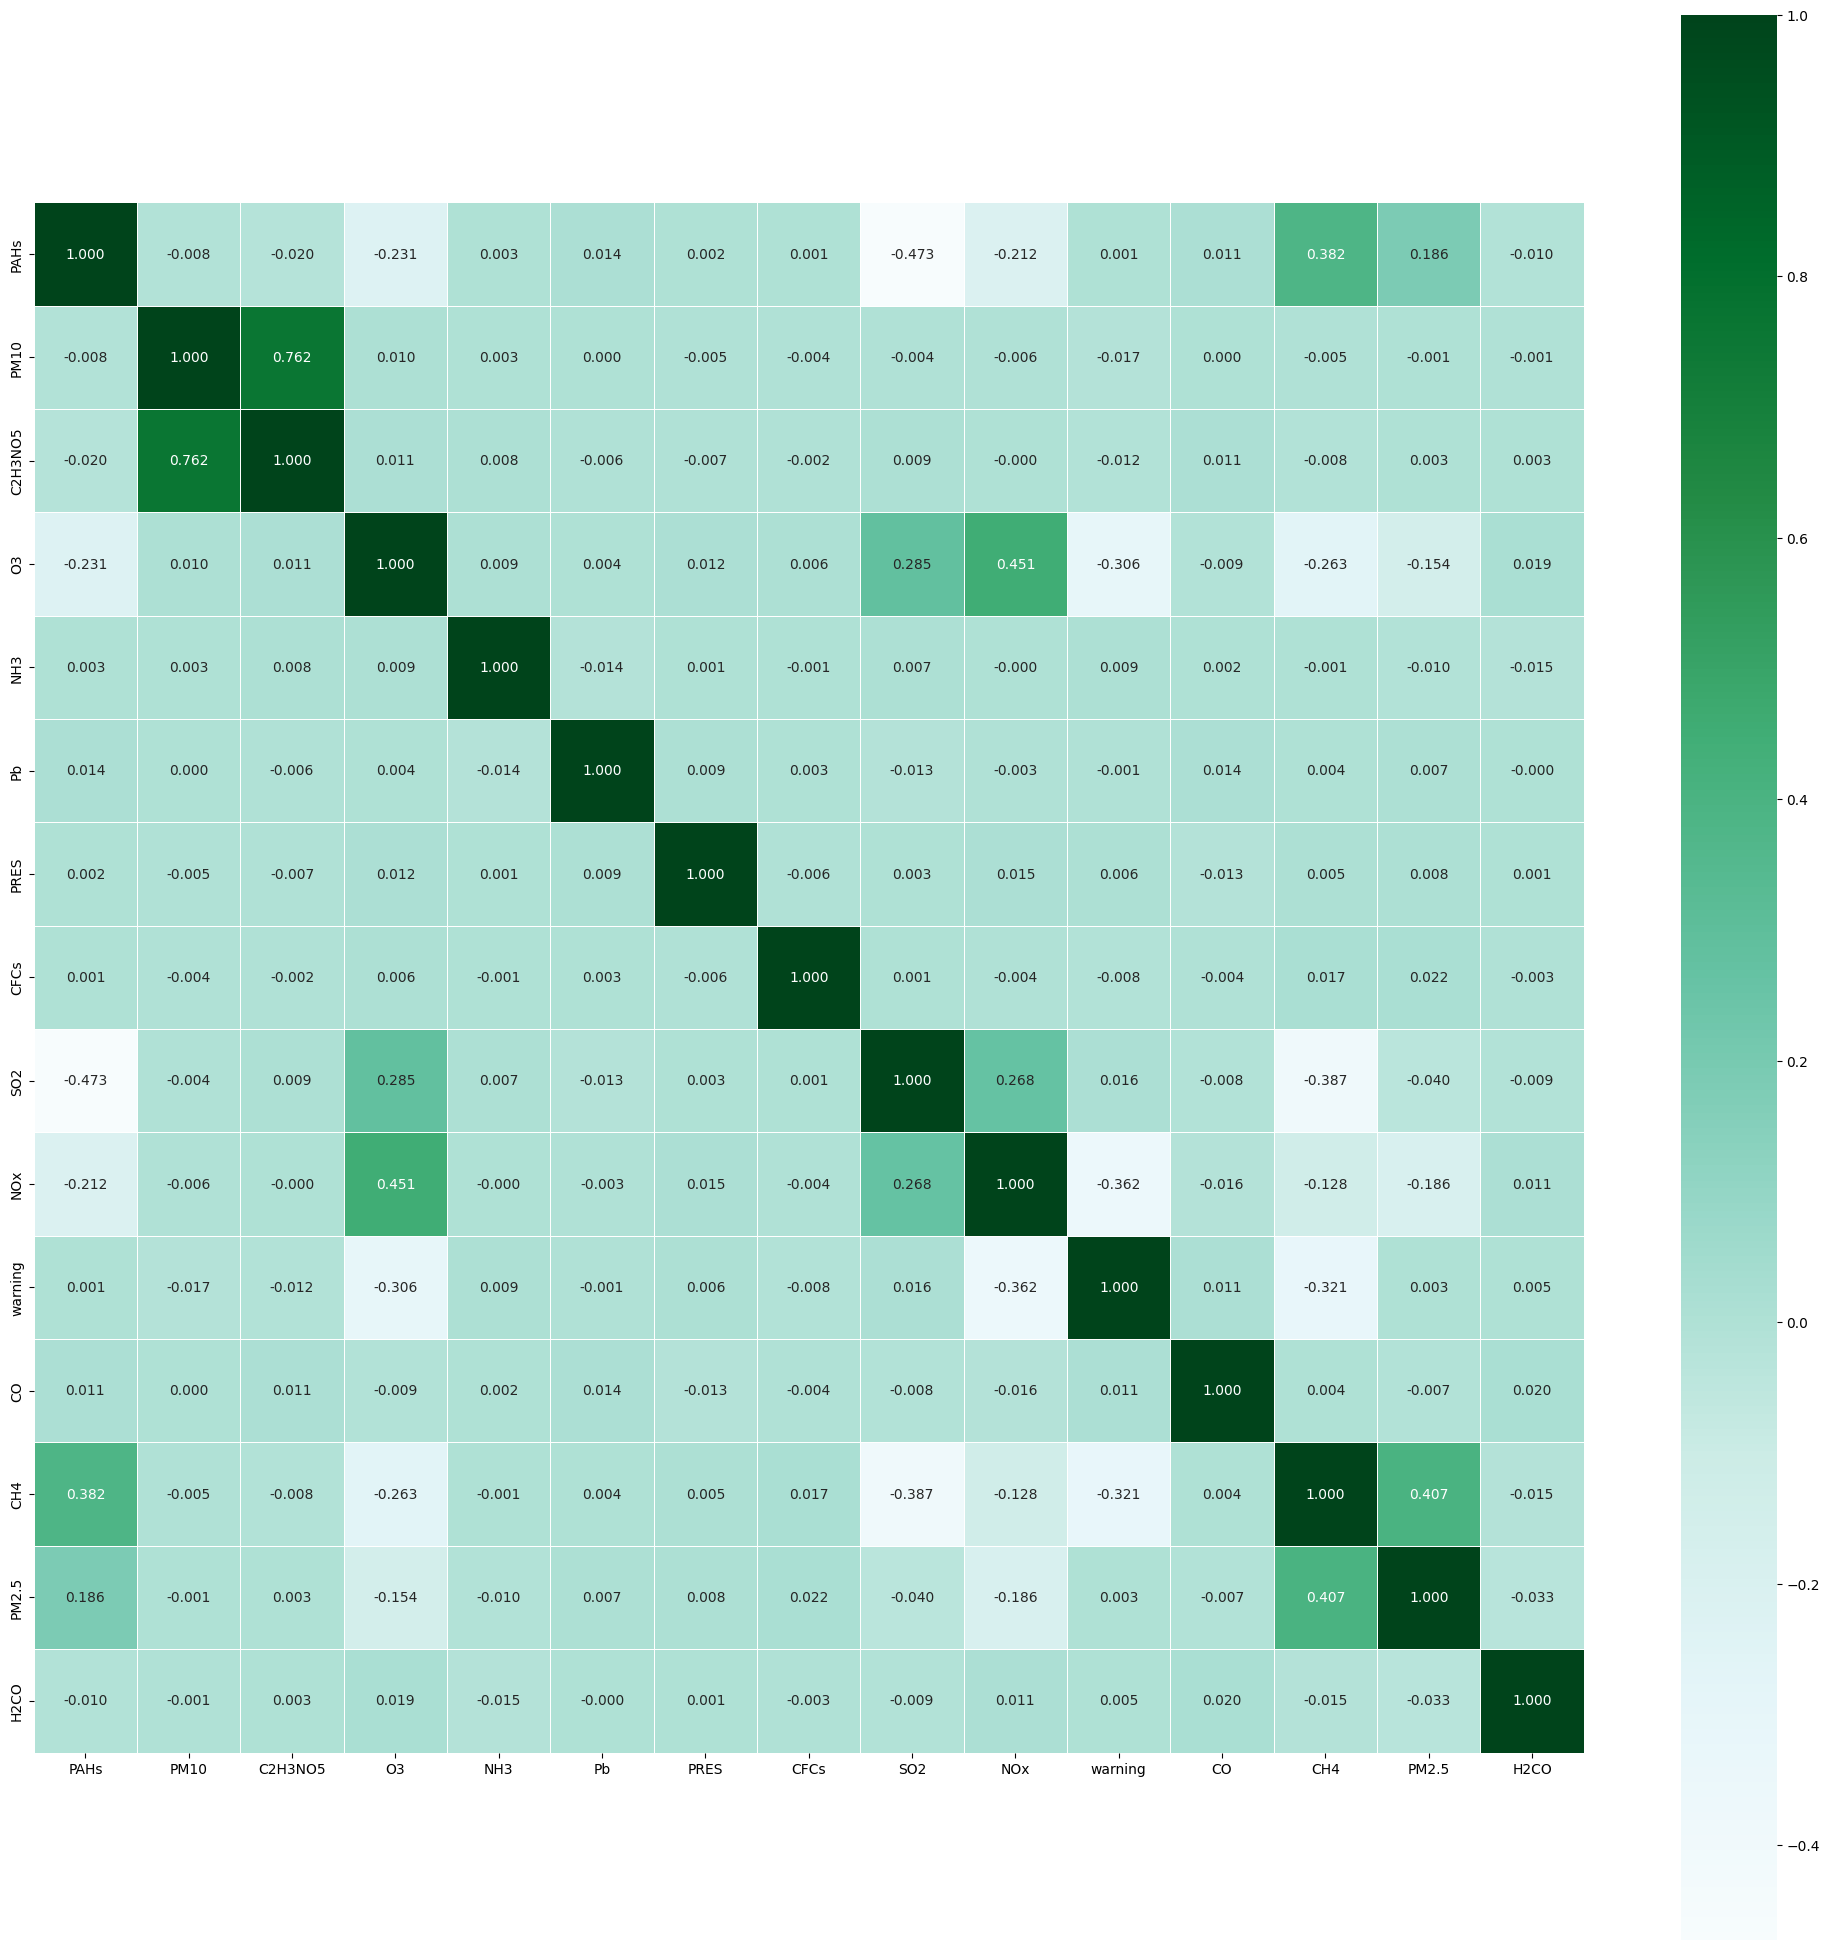

In [62]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Výpočet korelácie metódou zmananím.

In [63]:
findDiffCorrelation(tmp_data)

PAHs       0.004411
PM10       0.002306
C2H3NO5    0.002507
O3         0.004091
NH3        0.002321
Pb         0.004276
PRES       0.004411
CFCs       0.003531
SO2        0.004270
NOx        0.001945
warning    0.004270
CO         0.004276
CH4        0.004091
PM2.5      0.004206
H2CO       0.004293
dtype: float64

Výhodou tohto prístupu je, že sa nám heatmapa zmenila len minimálne. Nevýhodou je, že nám zmizlo 702 záznamov.
To nám predstavuje 5.87% dát.

In [64]:
(len(data)-len(tmp_data))/(len(data)) * 100

5.4953365263423235

2. metóda je nahradenie N/A hodnôt mediánom 

In [65]:
temp_data_median = data.copy()
temp_data_median.fillna(temp_data_median.iloc[: , :15].median(), inplace=True)
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt mediánom")
findDiffCorrelation(temp_data_median)

Rozdiel v korelácii po nahradení chýbajúcich hodnôt mediánom


PAHs       0.002376
PM10       0.000087
C2H3NO5    0.000279
O3         0.000864
NH3        0.000122
Pb         0.000054
PRES       0.000129
CFCs       0.000080
SO2        0.002376
NOx        0.000830
warning    0.000830
CO         0.000094
CH4        0.001635
PM2.5      0.000859
H2CO       0.000093
dtype: float64

Vykreslíme si heatmapu

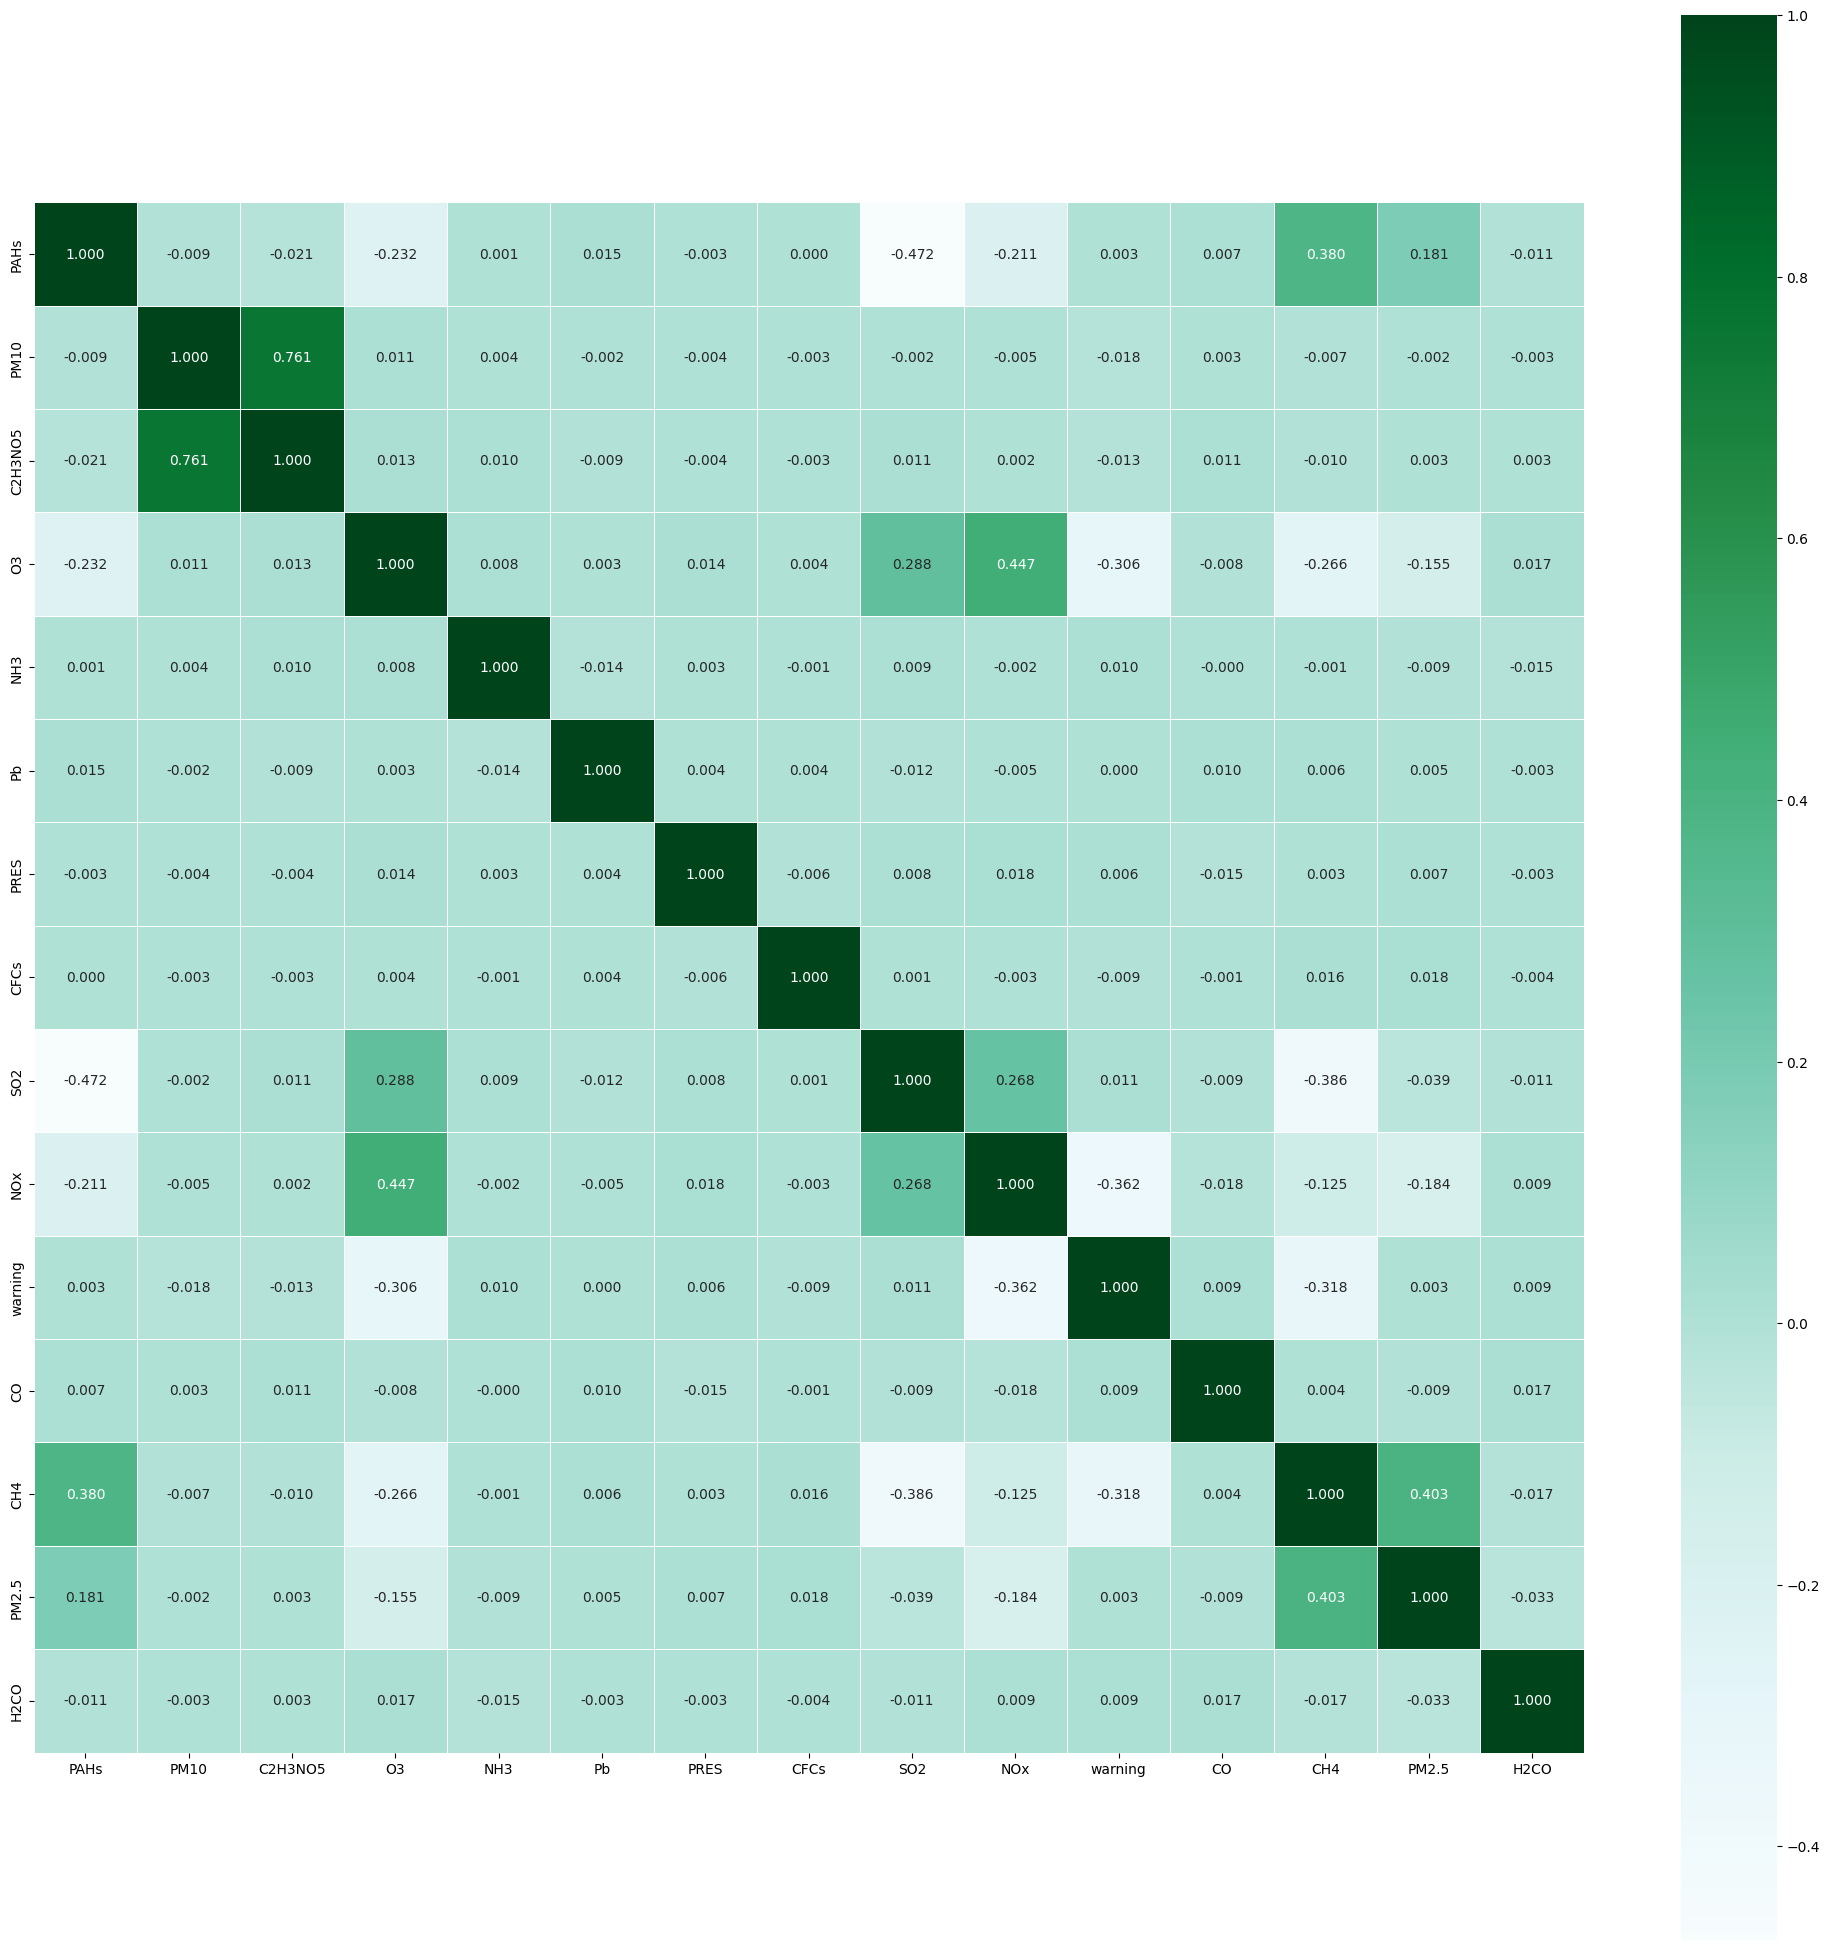

In [66]:
plt.figure(figsize=(25,25))
sns.heatmap(temp_data_median.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

3.Nahradenie chýbajúcich hodnôt priemerom


In [67]:
tmp_data_average = data.copy()
tmp_data_average.fillna(tmp_data_average.iloc[: , :16].mean(), inplace=True)
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt priemerom")
findDiffCorrelation(tmp_data_average)

Rozdiel v korelácii po nahradení chýbajúcich hodnôt priemerom


PAHs       0.002436
PM10       0.000032
C2H3NO5    0.000060
O3         0.000820
NH3        0.000059
Pb         0.000056
PRES       0.000033
CFCs       0.000021
SO2        0.002436
NOx        0.000741
warning    0.000692
CO         0.000059
CH4        0.001568
PM2.5      0.000779
H2CO       0.000138
dtype: float64

Vykreslíme si heatmapu

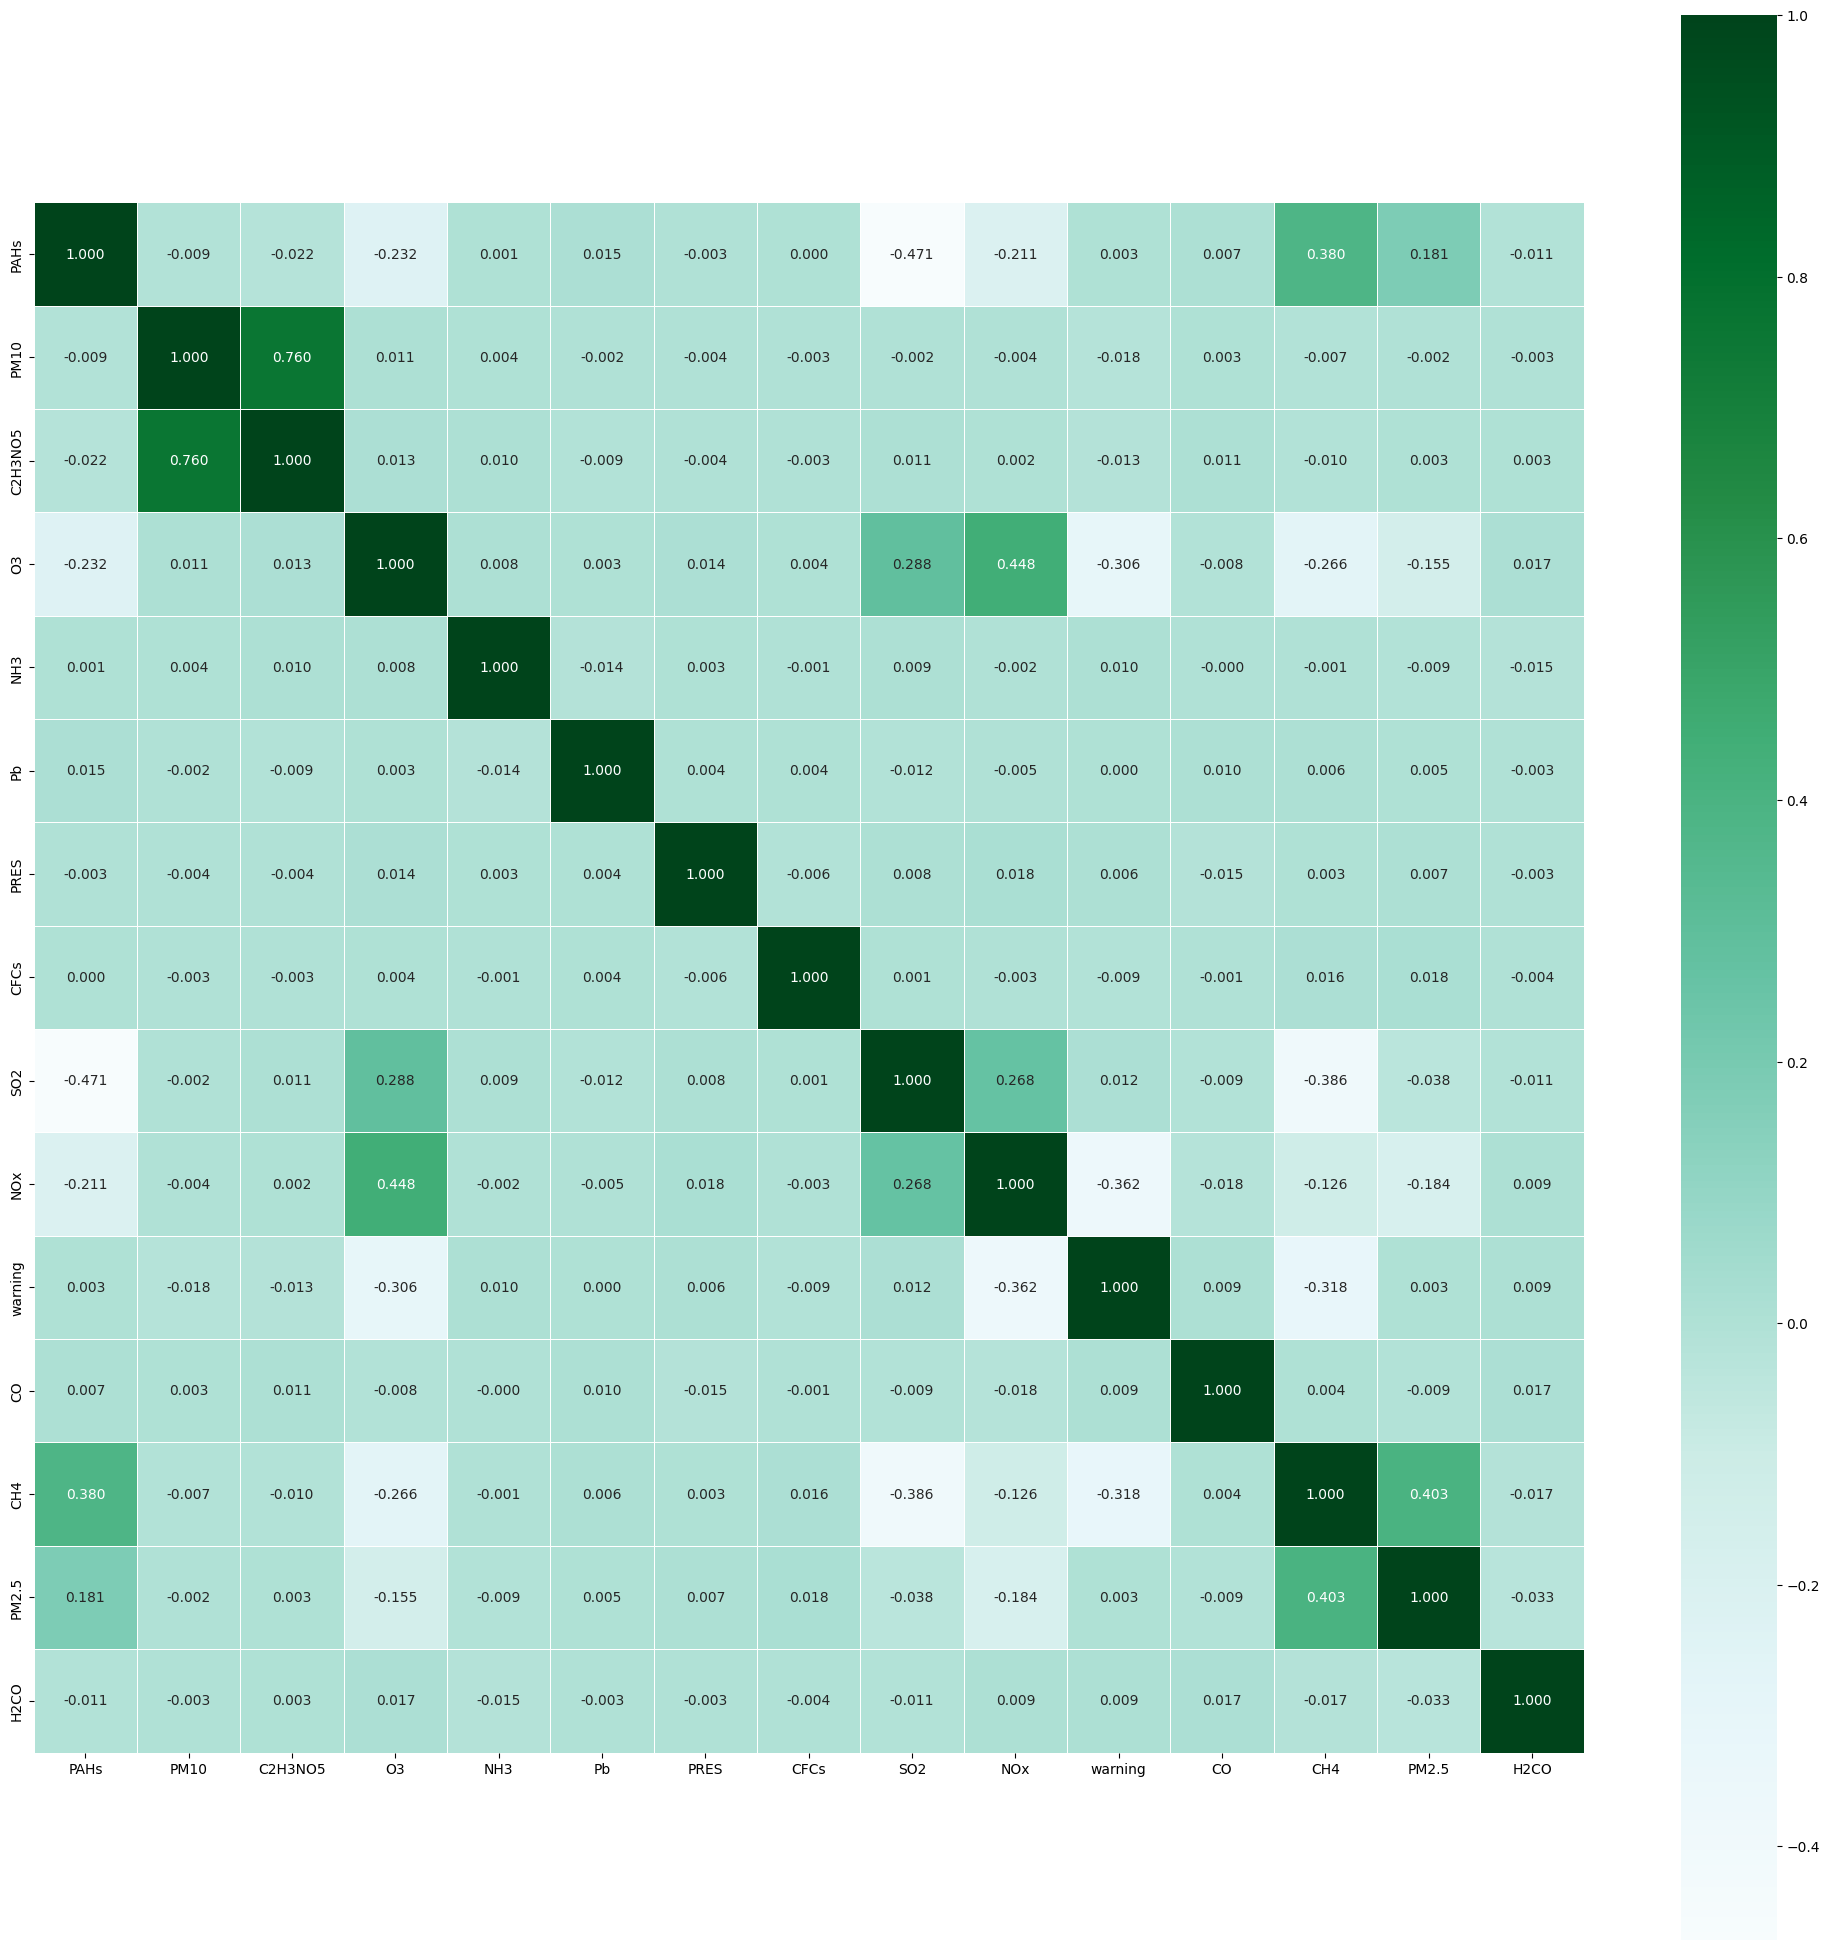

In [68]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data_average.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

In [69]:
tmp_data_knn = data.copy()
imputer = KNNImputer(n_neighbors=2)
tmp_data_measurements = tmp_data_knn.iloc[:, :15]
tmp_data_measurements = imputer.fit_transform(tmp_data_measurements)
tmp_data_knn.iloc[:, :15] = tmp_data_measurements
print("Rozdiel v korelácii po nahradení chýbajúcich hodnôt kNN")
findDiffCorrelation(tmp_data_knn)


Rozdiel v korelácii po nahradení chýbajúcich hodnôt kNN


PAHs       0.000782
PM10       0.000476
C2H3NO5    0.000444
O3         0.000500
NH3        0.000933
Pb         0.000987
PRES       0.000987
CFCs       0.000675
SO2        0.000782
NOx        0.000976
warning    0.000976
CO         0.000611
CH4        0.000933
PM2.5      0.000718
H2CO       0.000685
dtype: float64

Vykreslíme si heatmapu

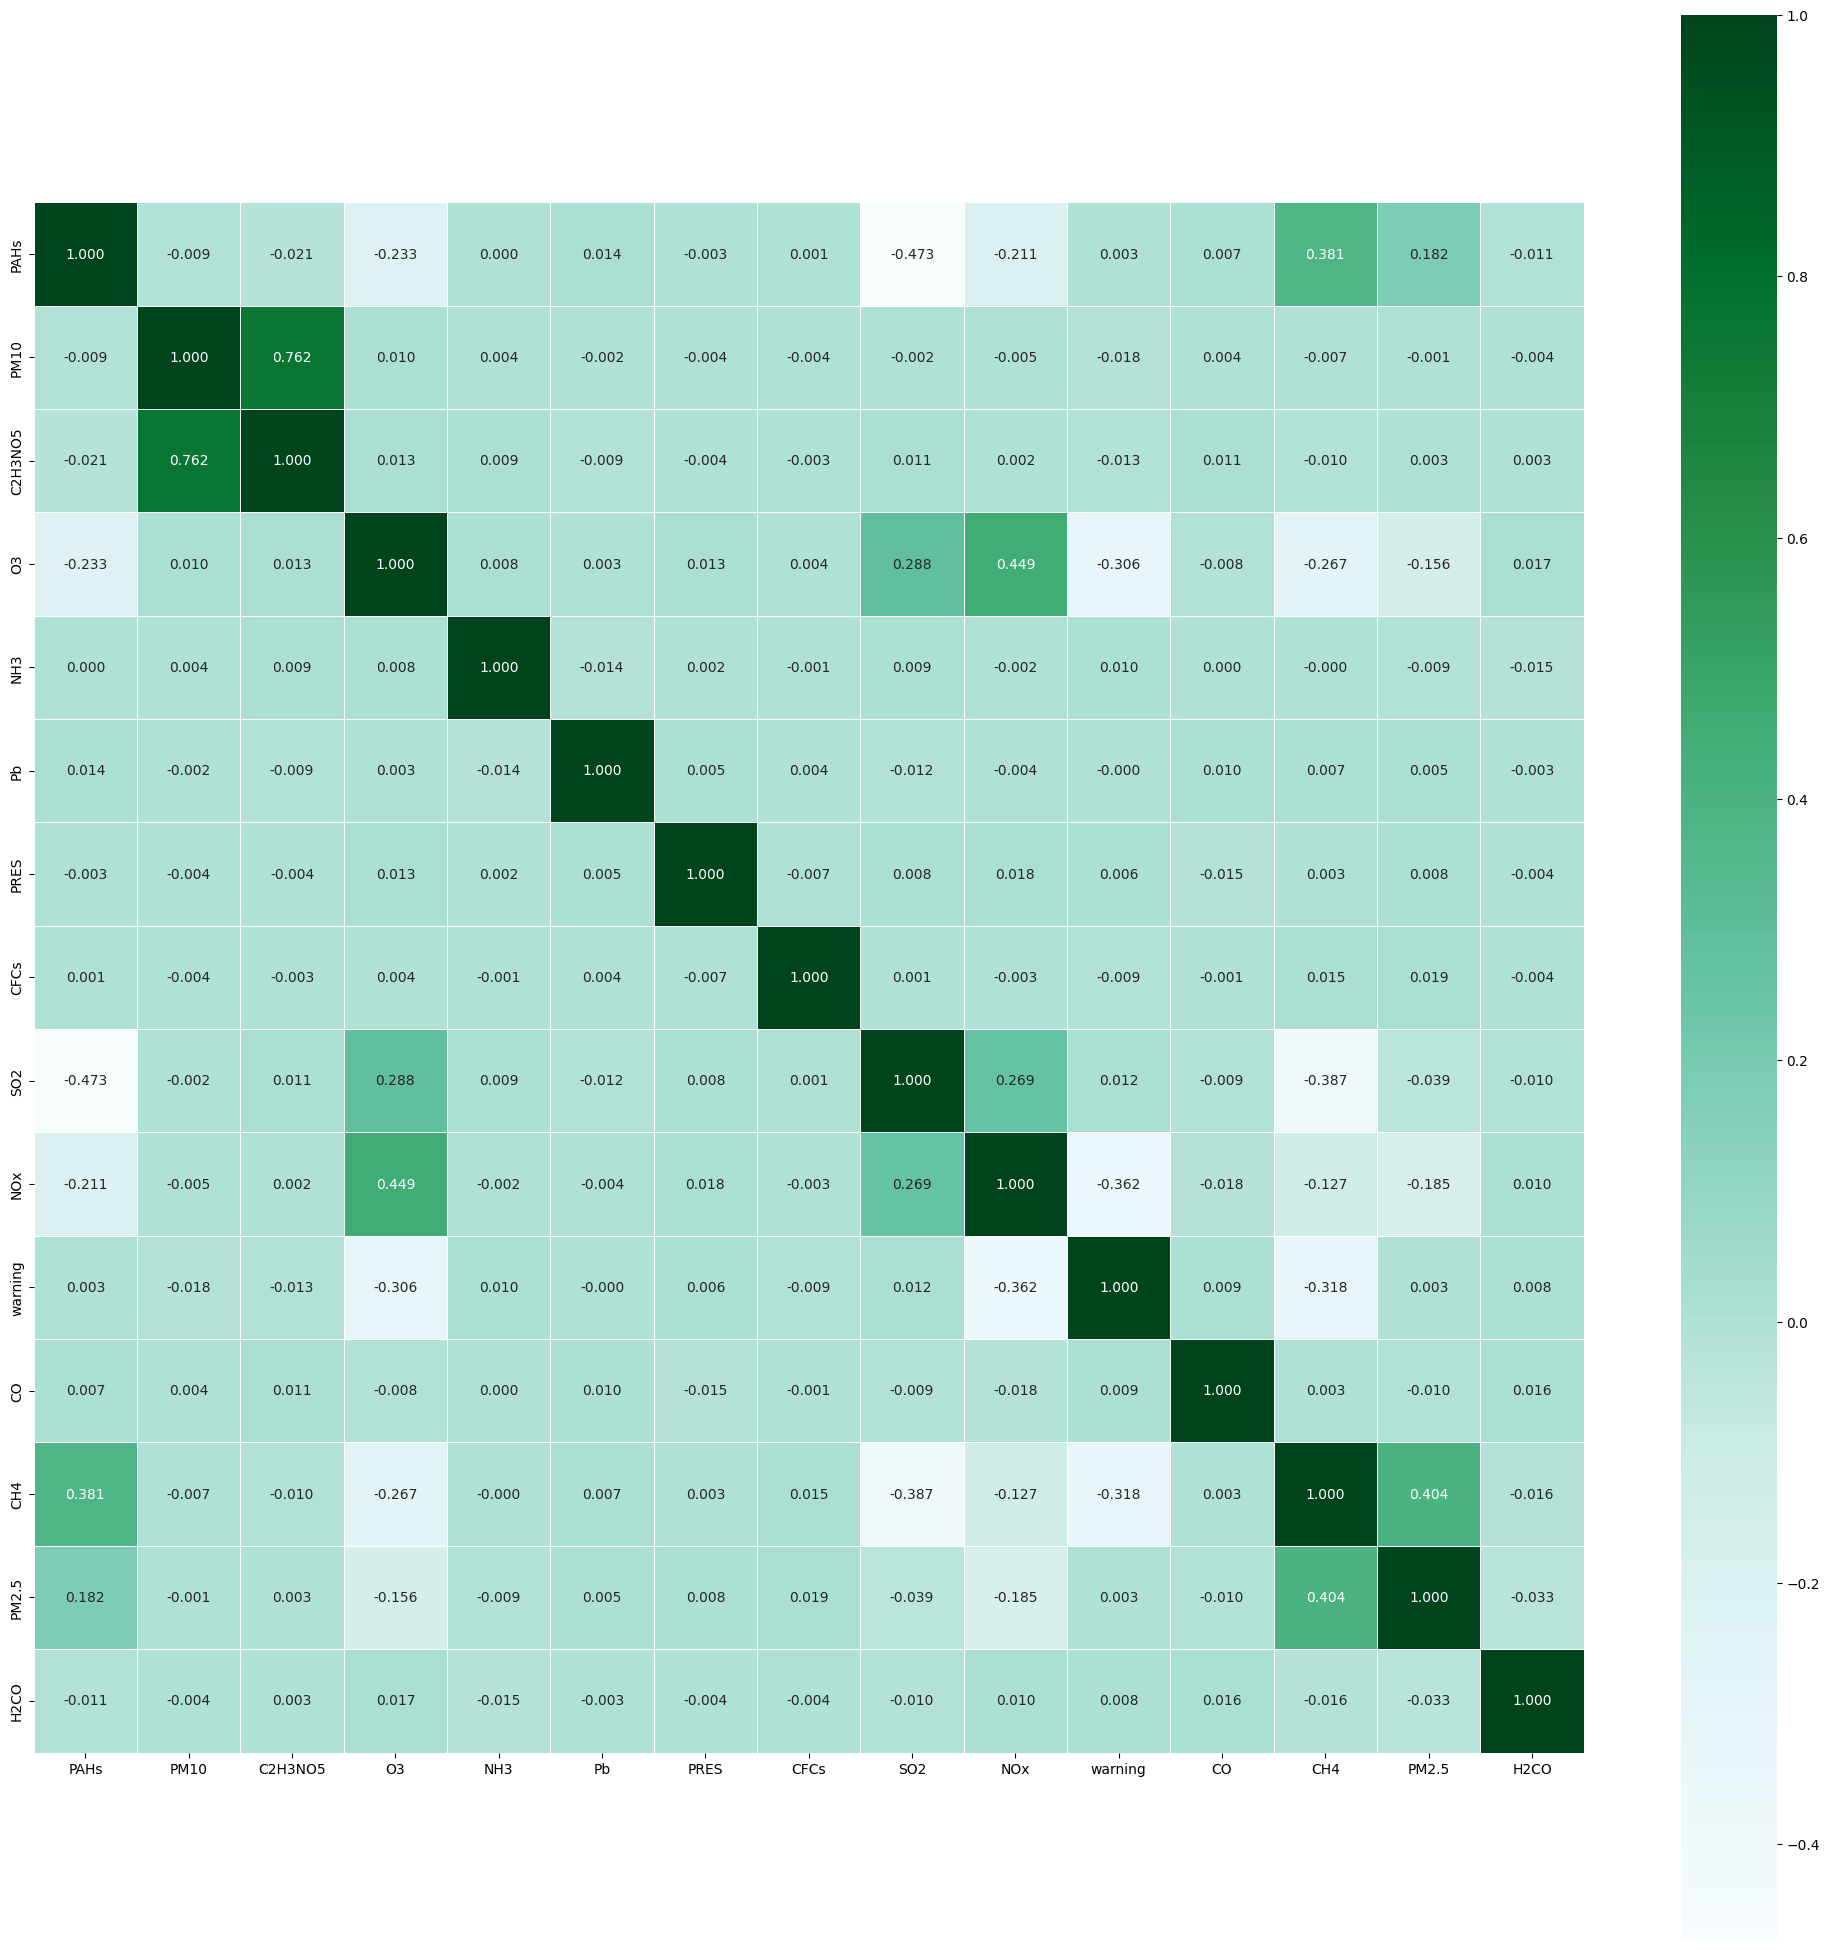

In [70]:
plt.figure(figsize=(25,25))
sns.heatmap(tmp_data_knn.iloc[: , :15].corr(), annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'BuGn');

Nájdeme, ktorá z metód bola najefektívnejšia

In [28]:
diff_corr_del = abs(tmp_data.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_median = abs(temp_data_median.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_average = abs(tmp_data_average.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
diff_corr_knn = abs(tmp_data_knn.iloc[: , :15].corr() - data.iloc[: , :15].corr()).mean().mean()
print("Priemerná odchýlka korelácie od pôvodných dát po zmazaní chýbajúcich hodnôt: ", diff_corr_del)
print("Priemerná odchýlka korelácie od pôvodných dát po nahradení chýbajúcich hodnôt medianom: ", diff_corr_median)
print("Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt priemerom: ", diff_corr_average)
print("Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt kNN: ",diff_corr_knn)
listik = [diff_corr_del,diff_corr_median,diff_corr_average,diff_corr_knn]
print("Najmenšia odchýlka je:",min(listik))
  

Priemerná odchýlka korelácie od pôvodných dát po zmazaní chýbajúcich hodnôt:  0.0018102455340275468
Priemerná odchýlka korelácie od pôvodných dát po nahradení chýbajúcich hodnôt medianom:  0.0003023372218485836
Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt priemerom:  0.0002344439358108186
Priemerná odchýlka korelácie od pôvodných dát  po nahradení chýbajúcich hodnôt kNN:  0.0004464733722219487
Najmenšia odchýlka je: 0.0002344439358108186


Z priemerových odchýliek vidíme, že najlepšie pre nás bude použiť nahradenie hodnôt priemerom.   

In [29]:
data = tmp_data_average.copy()

### Odstránenie vychýlených hodnôt (outlierov)

In [30]:
for column in data.describe().columns:
    find_outliers(data[column],column)

Počet outlierov v stĺpci PAHs je 21
Počet outlierov v stĺpci PM10 je 31
Počet outlierov v stĺpci C2H3NO5 je 217
Počet outlierov v stĺpci O3 je 38
Počet outlierov v stĺpci NH3 je 32
Počet outlierov v stĺpci Pb je 31
Počet outlierov v stĺpci PRES je 0
Počet outlierov v stĺpci CFCs je 37
Počet outlierov v stĺpci SO2 je 27
Počet outlierov v stĺpci NOx je 56
Počet outlierov v stĺpci warning je 0
Počet outlierov v stĺpci CO je 30
Počet outlierov v stĺpci CH4 je 19
Počet outlierov v stĺpci PM2.5 je 24
Počet outlierov v stĺpci H2CO je 26
Počet outlierov v stĺpci TEMP je 28
Počet outlierov v stĺpci latitude je 45
Počet outlierov v stĺpci longitude je 0


Skopírujeme si dáta, aby sme vedeli vykonávať testy a nemenili sme priamo naše dáta.

In [31]:
tmp_data = data.copy()

In [32]:
transform(tmp_data)

,PAHs,PM10,C2H3NO5,O3,NH3,Pb,PRES,CFCs,SO2,NOx,warning,CO,CH4,PM2.5,H2CO,TEMP,latitude,longitude,station
0,7.226280,9.070790,2.635330,9.956520,9.21864,29.988020,1093.161570,67.383610,9.896820,10.31364,0.0,8.368100,9.75090,10.19732,59.16382,1.58478,-5.85746,144.23058,Mount Hagen
3,10.393720,8.255410,1.197070,8.987720,9.82297,47.153610,1063.438960,69.629540,8.292850,10.26103,0.0,8.477720,9.60717,7.09990,65.37280,13.19832,8.88649,2.59753,Tchaourou
4,9.564410,8.432780,1.321370,5.894742,8.08426,47.942240,1111.555510,77.840350,8.422760,6.11983,1.0,8.970450,8.89398,8.22953,47.62991,3.92248,10.10649,76.35484,Alwaye
7,10.787990,9.806910,5.289640,6.234200,8.38204,70.796852,1156.281810,60.300564,5.842520,8.65345,1.0,7.144004,11.94774,9.47408,68.73458,18.35811,-21.98333,-59.13316,Tandil
11,5.641920,9.361080,3.447360,12.022130,8.93778,45.687780,1185.273020,67.192460,11.778902,10.49590,1.0,9.067820,6.62910,6.62591,56.52691,30.99446,42.22718,14.39024,Lanciano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25531,7.688750,9.535790,4.268000,9.413410,7.17104,28.631070,1192.692388,65.513060,10.008210,9.28442,0.0,7.487370,8.58958,7.85547,45.55913,15.71239,21.53889,71.57737,Gariadhar
25534,7.994790,9.646130,4.786920,10.148720,9.23772,66.960970,1167.874010,69.358600,9.394190,9.82530,0.0,8.519670,10.46974,10.76934,47.86523,27.31949,54.03876,30.28491,Kolomyagi
25536,7.669970,9.331370,3.460290,10.384170,9.97797,41.852620,1134.353010,63.387570,9.835230,9.77990,0.0,8.732990,9.86713,10.52182,62.45908,17.54827,39.59611,27.02444,Edremit
25537,8.793407,8.137870,1.236080,9.698620,9.38402,39.421210,1079.258760,74.120960,8.878630,10.33038,1.0,9.367640,8.35001,7.87697,40.20674,20.82077,-4.24444,-42.29444,Barras


In [33]:
for column in data.describe().columns:
    find_outliers(tmp_data[column],column)

Počet outlierov v stĺpci PAHs je 0
Počet outlierov v stĺpci PM10 je 0
Počet outlierov v stĺpci C2H3NO5 je 0
Počet outlierov v stĺpci O3 je 0
Počet outlierov v stĺpci NH3 je 0
Počet outlierov v stĺpci Pb je 0
Počet outlierov v stĺpci PRES je 0
Počet outlierov v stĺpci CFCs je 0
Počet outlierov v stĺpci SO2 je 0
Počet outlierov v stĺpci NOx je 0
Počet outlierov v stĺpci warning je 0
Počet outlierov v stĺpci CO je 0
Počet outlierov v stĺpci CH4 je 0
Počet outlierov v stĺpci PM2.5 je 0
Počet outlierov v stĺpci H2CO je 0
Počet outlierov v stĺpci TEMP je 0
Počet outlierov v stĺpci latitude je 0
Počet outlierov v stĺpci longitude je 0


Ako vidíme, tak outlierov nám to úspešne odstránilo. Pri latitude a longitude outlierov neriešime - toto sú súradnice stanice.

In [34]:
tmp_data = data.copy()

In [35]:
z_scores = stats.zscore(tmp_data.iloc[:,:16]) 
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores <= 3).all(axis=1)
tmp_data = tmp_data[filtered_entries]
print(tmp_data)

            PAHs     PM10  C2H3NO5        O3      NH3        Pb        PRES  \
0       7.226280  9.07079  2.63533   9.95652  9.21864  29.98802  1093.16157   
3      10.393720  8.25541  1.19707   8.98772  9.82297  47.15361  1063.43896   
4       9.564410  8.43278  1.32137   4.43270  8.08426  47.94224  1111.55551   
7      10.787990  9.80691  5.28964   6.23420  8.38204  72.85236  1156.28181   
11      5.641920  9.36108  3.44736  12.02213  8.93778  45.68778  1185.27302   
...          ...      ...      ...       ...      ...       ...         ...   
25531   7.688750  9.53579  4.26800   9.41341  6.11207  25.79962  1194.52692   
25534   7.994790  9.64613  4.78692  10.14872  9.23772  66.96097  1167.87401   
25536   7.669970  9.33137  3.46029  10.38417  9.97797  41.85262  1134.35301   
25537   8.793407  8.13787  1.23608   9.69862  9.38402  39.42121  1079.25876   
25539   6.097740  6.50756  0.36799   7.84105  9.76842  23.67090  1169.72651   

           CFCs       SO2       NOx  warning       

In [36]:
for column in data.describe().columns:
    find_outliers(tmp_data[column],column)

Počet outlierov v stĺpci PAHs je 1
Počet outlierov v stĺpci PM10 je 5
Počet outlierov v stĺpci C2H3NO5 je 267
Počet outlierov v stĺpci O3 je 3
Počet outlierov v stĺpci NH3 je 2
Počet outlierov v stĺpci Pb je 9
Počet outlierov v stĺpci PRES je 0
Počet outlierov v stĺpci CFCs je 5
Počet outlierov v stĺpci SO2 je 1
Počet outlierov v stĺpci NOx je 18
Počet outlierov v stĺpci warning je 0
Počet outlierov v stĺpci CO je 4
Počet outlierov v stĺpci CH4 je 2
Počet outlierov v stĺpci PM2.5 je 7
Počet outlierov v stĺpci H2CO je 11
Počet outlierov v stĺpci TEMP je 2
Počet outlierov v stĺpci latitude je 43
Počet outlierov v stĺpci longitude je 0


In [37]:
data = transform(data)

##  Realizácia predspracovania dát
Rozdelenie na trénovaciu a testovaciu sadu 

In [38]:
training_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
 

Pripravenie trénovacieho setu na strojové učenie  

In [39]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9559 entries, 8562 to 15387
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PAHs       9559 non-null   float64
 1   PM10       9559 non-null   float64
 2   C2H3NO5    9559 non-null   float64
 3   O3         9559 non-null   float64
 4   NH3        9559 non-null   float64
 5   Pb         9559 non-null   float64
 6   PRES       9559 non-null   float64
 7   CFCs       9559 non-null   float64
 8   SO2        9559 non-null   float64
 9   NOx        9559 non-null   float64
 10  warning    9559 non-null   float64
 11  CO         9559 non-null   float64
 12  CH4        9559 non-null   float64
 13  PM2.5      9559 non-null   float64
 14  H2CO       9559 non-null   float64
 15  TEMP       9559 non-null   float64
 16  latitude   9559 non-null   float64
 17  longitude  9559 non-null   float64
 18  station    9559 non-null   object 
dtypes: float64(18), object(1)
memory usage: 1.5+

Vytvoríme grafy podľa stĺpcov, pre ktoré sme tvorili hypotézy, pretože je tam vysoká šanca, že sa zobrazia vysoké hodnoty "warning"    

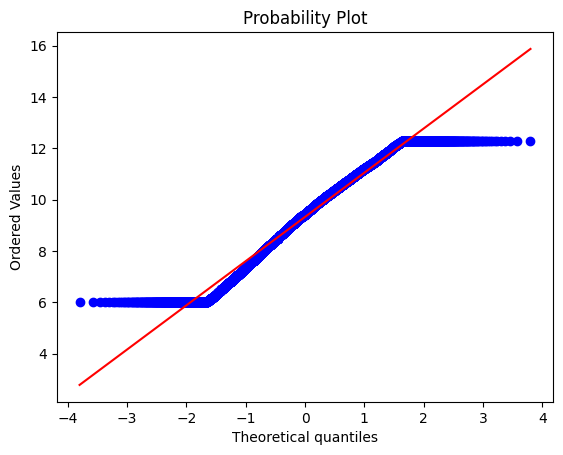

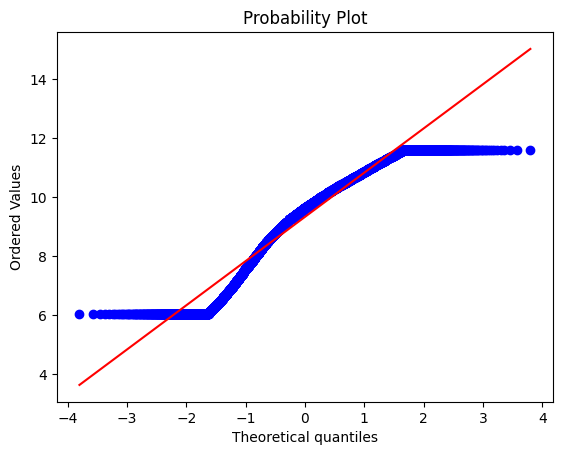

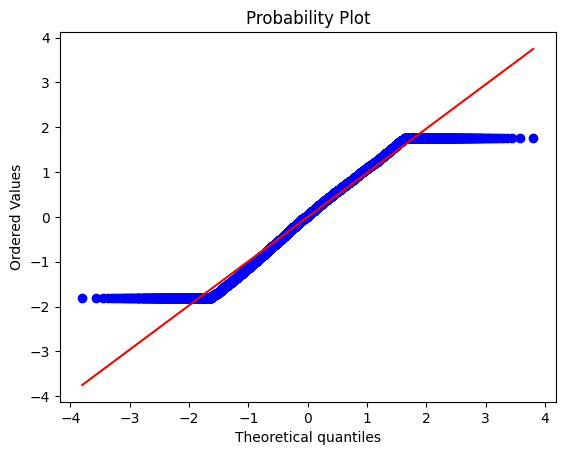

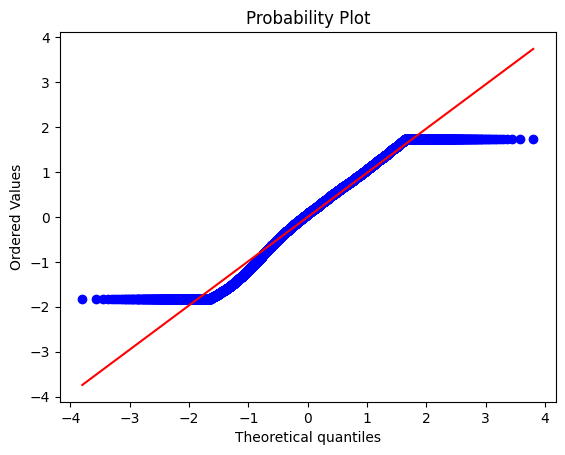

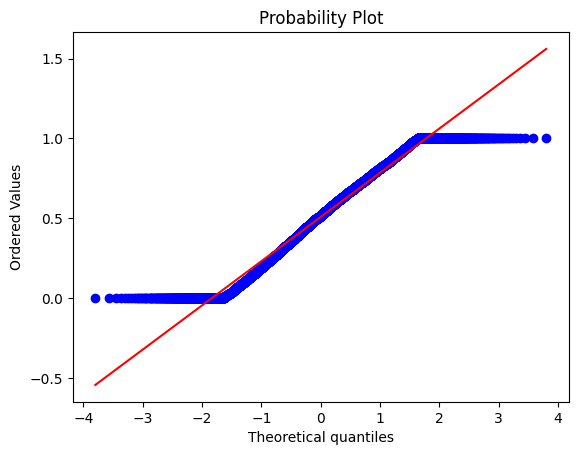

ValueError: Unknown label type: 'continuous'

In [40]:
# Show columns
training_data.columns



stats.probplot(training_data["CH4"], plot=sns.mpl.pyplot, fit=True)
plt.show()

stats.probplot(training_data["NOx"], plot=sns.mpl.pyplot, fit=True)
plt.show()

# Using PowerTransformer to normalize data
pt = PowerTransformer()
training_data.iloc[:, :16] = pt.fit_transform(training_data.iloc[:, :16])
test_data.iloc[:, :16] = pt.transform(test_data.iloc[:, :16])

stats.probplot(training_data["CH4"], plot=sns.mpl.pyplot, fit=True)
plt.show()

stats.probplot(training_data["NOx"], plot=sns.mpl.pyplot, fit=True)
plt.show()

# Using MinMaxScaler to normalize data
scaler = MinMaxScaler()
training_data.iloc[:, :16] = scaler.fit_transform(training_data.iloc[:, :16])
test_data.iloc[:, :16] = scaler.transform(test_data.iloc[:, :16])

stats.probplot(training_data["CH4"], plot=sns.mpl.pyplot, fit=True)
plt.show()

test_out = training_data["warning"]
test_input = training_data.iloc[:, :16].copy()
test_input.drop("warning", axis=1, inplace=True)
test_out

# use SelectFromModel to select features by LogisticRegression

# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.3
sfm = SelectFromModel(LogisticRegression(), threshold=0.3)

# Train the selector
sfm.fit(test_input, test_out)

# Print the names of the most important features sorted by importance (from most to least)
for feature_list_index in sfm.get_support(indices=True):
    print(test_input.columns[feature_list_index])
    


    



In [41]:
test_out.unique()

array([1.        , 0.        , 0.54566967])